In [0]:
# !pip install -q kaggle
# !pip install -q kaggle-cli

In [0]:
# from google.colab import files

# #retrieve uploaded file
# uploaded = files.upload()

In [0]:
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !ls ~/.kaggle

In [0]:
# #@title Verify Content of the `kaggle.json` file
# # Verify json content
# verify_content = True #@param {type: "boolean"}

# !ls -l ~/.kaggle
# !cat ~/.kaggle/kaggle.json

In [0]:
# !kaggle competitions download -c aptos2019-blindness-detection

In [0]:
# import os
# for dirname, _, filenames in os.walk('/content'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# print(os.getcwd())

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# !mv './sample_submission.csv' './drive/My Drive/Kaggle/APTOS/data/'
# !mv './test.csv' './drive/My Drive/Kaggle/APTOS/data/'
# !mv './train.csv' './drive/My Drive/Kaggle/APTOS/data/'

In [0]:
# !unzip './test_images.zip' -d './drive/My Drive/Kaggle/APTOS/data/test_images'
# !unzip './train_images.zip' -d './drive/My Drive/Kaggle/APTOS/data/train_images'

In [10]:
import os
print(len(os.listdir('./drive/My Drive/Kaggle/APTOS/data/train_images')))
print(len(os.listdir('./drive/My Drive/Kaggle/APTOS/data/test_images')))

3662
1928


In [0]:
BASE_DIR = './drive/My Drive/Kaggle/APTOS/data/'
TRAIN_IMAGE_DIR = './drive/My Drive/Kaggle/APTOS/data/train_images'
TEST_IMAGE_DIR = './drive/My Drive/Kaggle/APTOS/data/test_images'
train_csv = './drive/My Drive/Kaggle/APTOS/data/train.csv'
test_csv = './drive/My Drive/Kaggle/APTOS/data/test.csv'
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [13]:
train_df = pd.read_csv(train_csv)
train_df.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [14]:
test_df = pd.read_csv(test_csv)
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


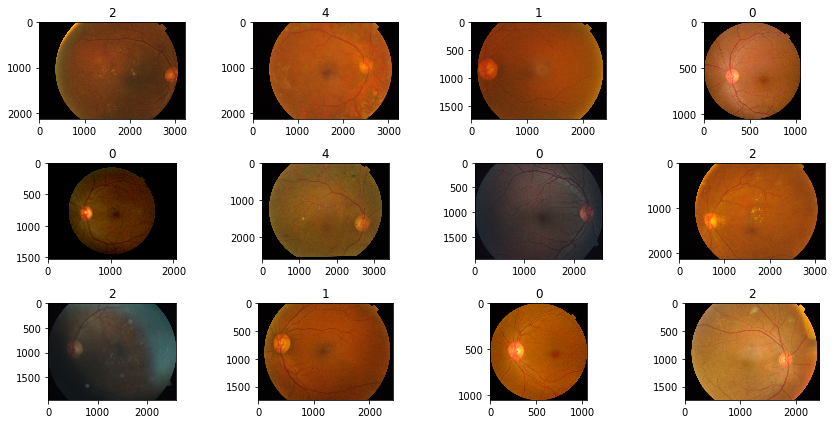

In [15]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(3*columns, 2*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'./drive/My Drive/Kaggle/APTOS/data/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [0]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'

In [0]:
test_df['id_code'] = test_df['id_code'].astype(str)+'.png'

In [18]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [19]:
train_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'training',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)
val_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'validation',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = None,
    x_col = 'id_code',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    directory = TEST_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [20]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
encoded_diagnosis = onehot_encoder.fit_transform(train_df[['diagnosis']])
print(encoded_diagnosis)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers import Dropout, GaussianNoise, GaussianDropout,GlobalAveragePooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers

In [22]:
from keras.applications.inception_v3 import InceptionV3
inet = InceptionV3(include_top = False, weights='imagenet', input_shape=(224,224,3))
model = Sequential()
model.add(inet)
# model.add(Conv2D(filters = 1024, kernel_size = (2,2),padding = 'same'))
# model.add(BatchNormalization())
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)
# model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [25]:
history = model.fit_generator(generator=train_gen,              
                                    steps_per_epoch=len(train_gen)//BATCH_SIZE,
                                    validation_data=val_gen,                    
                                    validation_steps=len(val_gen)//BATCH_SIZE,
                                    epochs=50,
                                    callbacks = [early_stop], 
                                    use_multiprocessing = True,
                                    verbose=1)



Epoch 1/50
11/11 [==============================] - 64s 6s/step - loss: 0.6549 - acc: 0.6114 - val_loss: 0.4352 - val_acc: 0.8813
Epoch 2/50
11/11 [==============================] - 20s 2s/step - loss: 0.4418 - acc: 0.8659 - val_loss: 0.4065 - val_acc: 0.8375
Epoch 3/50
11/11 [==============================] - 26s 2s/step - loss: 0.3594 - acc: 0.8670 - val_loss: 0.2865 - val_acc: 0.8875
Epoch 4/50
11/11 [==============================] - 26s 2s/step - loss: 0.3071 - acc: 0.8841 - val_loss: 0.2825 - val_acc: 0.8938
Epoch 5/50
11/11 [==============================] - 28s 3s/step - loss: 0.3221 - acc: 0.8670 - val_loss: 0.2992 - val_acc: 0.8938
Epoch 6/50
11/11 [==============================] - 27s 2s/step - loss: 0.2575 - acc: 0.9057 - val_loss: 0.2298 - val_acc: 0.9062
Epoch 7/50
11/11 [==============================] - 25s 2s/step - loss: 0.2581 - acc: 0.8920 - val_loss: 0.2767 - val_acc: 0.8812
Epoch 8/50
11/11 [==============================] - 27s 2s/step - loss: 0.2679 - acc: 0.

In [26]:
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

121/121 [==============================] - 622s 5s/step


In [30]:
loss, acc = model.evaluate_generator(val_gen, steps=3, verbose=1)
print("Loss of the model: ",loss)
print("Accuracy of the model: ",acc)

3/3 [==============================] - 7s 2s/step
Loss of the model:  0.2875688622395198
Accuracy of the model:  0.8791666626930237


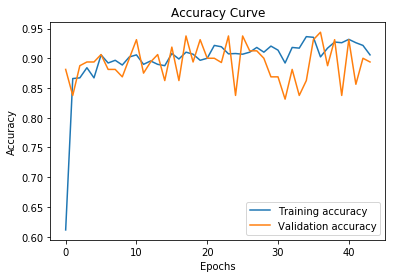

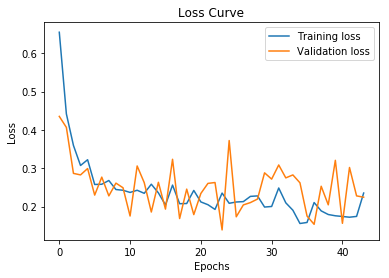

In [31]:
acc, val_acc = history.history['acc'], history.history['val_acc']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))
import matplotlib.pyplot as plt

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()